In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
import missingno as msno
import tensorflow as tf

# Import from sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder, LabelBinarizer, LabelEncoder
import category_encoders as ce
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier

# Set a random seed
from numpy.random import seed
seed(8)
from tensorflow.random import set_seed
set_seed(8)

# Data Visualization
sns.set_theme(context='notebook', style='darkgrid', palette='bright')

In [2]:
df = pd.read_csv('../data/df_clusters.csv')
df.head()

,name,artist,track_id,instrumentalness,danceability,energy,liveness,loudness,acousticness,valence,speechiness,tempo,key,time_signature,length,popularity,mood,mood_map,cluster
0,Kiss Me More (feat. SZA),Doja Cat,748mdHapucXQri7IAO8yFK,0.000158,0.762,0.701,0.1230,-3.541,0.23500,0.742,0.0286,110.968,8,4,208866,92,Happy,2,0
1,seaside_demo,SEB,73M0rMVx5CWE8M4uATSsto,0.000133,0.706,0.824,0.1110,-7.959,0.35500,0.860,0.0694,94.980,0,4,132000,54,Happy,2,0
2,Shivers,Ed Sheeran,6bQfNiqyCX7UaQSvVVGo4I,0.000000,0.788,0.859,0.0424,-2.724,0.28100,0.822,0.0856,141.020,2,4,207853,78,Happy,2,0
3,Heat Waves,Glass Animals,02MWAaffLxlfxAUY7c5dvx,0.000007,0.761,0.525,0.0921,-6.900,0.44000,0.531,0.0944,80.870,11,4,238805,85,Happy,2,0
4,Electric Love,BØRNS,2GiJYvgVaD2HtM8GqD9EgQ,0.001370,0.611,0.797,0.2600,-7.627,0.00543,0.518,0.0533,120.041,6,4,218106,82,Happy,2,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5849 entries, 0 to 5848
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5849 non-null   object 
 1   artist            5849 non-null   object 
 2   track_id          5849 non-null   object 
 3   instrumentalness  5849 non-null   float64
 4   danceability      5849 non-null   float64
 5   energy            5849 non-null   float64
 6   liveness          5849 non-null   float64
 7   loudness          5849 non-null   float64
 8   acousticness      5849 non-null   float64
 9   valence           5849 non-null   float64
 10  speechiness       5849 non-null   float64
 11  tempo             5849 non-null   float64
 12  key               5849 non-null   int64  
 13  time_signature    5849 non-null   int64  
 14  length            5849 non-null   int64  
 15  popularity        5849 non-null   int64  
 16  mood              5849 non-null   object 


#### **Null model:** 
###### Evaluate class imbalances
###### Classes are fairly balanced

In [4]:
df['mood'].value_counts(normalize=True)

Calm         0.283125
Energetic    0.247564
Sad          0.244315
Happy        0.224996
Name: mood, dtype: float64

#### **Pre-processing**
###### Set X and y for Base Model

In [5]:
# make copy of dataframe
df = df.copy()


# X audio features without clusters
X_audio = df[['danceability', 
               'energy', 
               'loudness', 
               'speechiness', 
               'acousticness',
               'instrumentalness', 
               'liveness', 
               'valence']]

y = df['mood_map']

#### **Pre-processing**

In [6]:
# set up train_test_split with stratification to include equal classes of each
X_train, X_test, y_train, y_test = train_test_split(X_audio, y, 
                                                     test_size=0.3, 
                                                     stratify=y, 
                                                     random_state=42)

# standardize X data
x = MinMaxScaler()
X_train_x = x.fit_transform(X_train)
X_test_x = x.transform(X_test)

# LabelBinarizer for multiclass classification response variable
x = LabelBinarizer()
y_train_x = x.fit_transform(y_train)
y_test_x = x.transform(y_test)

#### **Base Model**

In [7]:
def mood_model():
    
    n_input = X_train_x[0].shape

    model = Sequential()

    model.add(Dense(8, 
                    activation='relu', 
                    input_shape=(n_input)))
    
    model.add(Dense(8, 
                    activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(4, activation='softmax'))
    
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                               verbose=1, mode='auto')
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[['accuracy'],
                           [tf.keras.metrics.Precision()],
                           [tf.keras.metrics.Recall()]])

    return model

In [8]:
classifier = KerasClassifier(build_fn=mood_model,
                             epochs=200,
                             verbose=0)

history=classifier.fit(X_train_x,
               y_train_x,
               validation_data=(X_test_x, y_test_x),
               epochs=200,
               verbose=0)
print(f'Train score: {classifier.score(X_train_x, y_train_x)}')
print(f'Test score: {classifier.score(X_test_x, y_test_x)}')

Train score: 0.5693697929382324
Test score: 0.5692307949066162


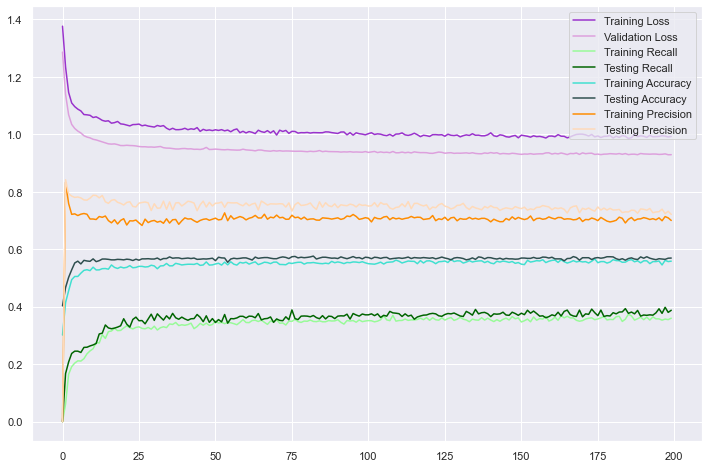

In [9]:
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
train_recall = history.history['recall']
test_recall = history.history['val_recall']
train_precision = history.history['precision']
test_precision = history.history['val_precision']
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='Training Loss', color="darkorchid")
plt.plot(history.history['val_loss'], label='Validation Loss', color='plum')
plt.plot(train_recall, label='Training Recall', color='palegreen')
plt.plot(test_recall, label='Testing Recall', color = 'darkgreen')
plt.plot(train_acc, label='Training Accuracy', color='turquoise')
plt.plot(test_acc, label='Testing Accuracy', color="darkslategray");
plt.plot(train_precision, label='Training Precision', color="darkorange")
plt.plot(test_precision, label='Testing Precision', color='peachpuff')
plt.legend();

In [10]:
print(f'Train score: {classifier.model.evaluate(X_train_x, y_train_x)}')
print(f'Test score: {classifier.model.evaluate(X_test_x, y_test_x)}')

128/128 [==============================] - 0s 936us/step - loss: 0.9596 - accuracy: 0.5694 - precision: 0.7154 - recall: 0.3862
Train score: [0.9596280455589294, 0.5693697929382324, 0.7153846025466919, 0.38617488741874695]
55/55 [==============================] - 0s 917us/step - loss: 0.9291 - accuracy: 0.5692 - precision: 0.7211 - recall: 0.3875
Test score: [0.9291154742240906, 0.5692307949066162, 0.7211028337478638, 0.38746437430381775]


In [11]:
y_preds=classifier.predict(X_test_x)

C:\Users\Brianna\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [12]:
classifier.classes_

array([0, 1, 2, 3])

In [13]:
accuracy_score(y_test, y_preds)

0.5692307692307692

In [14]:
print(f'Sad: {precision_score(y_test, y_preds, average=None)[0]}')
print(f'Calm: {precision_score(y_test, y_preds, average=None)[1]}')
print(f'Energetic: {precision_score(y_test, y_preds, average=None)[2]}')
print(f'Happy: {precision_score(y_test, y_preds, average=None)[3]}')

Sad: 0.5940766550522648
Calm: 0.8693693693693694
Energetic: 0.4036697247706422
Happy: 0.5268987341772152


In [15]:
print(f'Sad: {recall_score(y_test, y_preds, average=None)[0]}')
print(f'Calm: {recall_score(y_test, y_preds, average=None)[1]}')
print(f'Energetic: {recall_score(y_test, y_preds, average=None)[2]}')
print(f'Happy: {recall_score(y_test, y_preds, average=None)[3]}')

Sad: 0.7948717948717948
Calm: 0.38832997987927564
Energetic: 0.3341772151898734
Happy: 0.7672811059907834


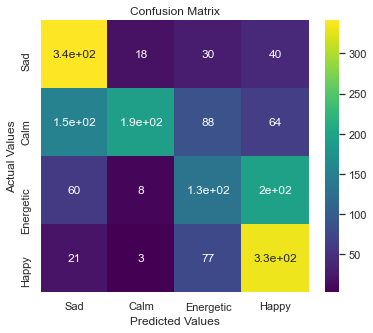

In [16]:
cm = confusion_matrix(y_test, y_preds, labels=classifier.classes_)
cm_df = pd.DataFrame(cm, index=['Sad', 'Calm', 'Energetic', 'Happy'], columns=['Sad', 'Calm', 'Energetic', 'Happy'])
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [17]:
print(f'Sad: {f1_score(y_test, y_preds, average=None)[0]}')
print(f'Calm: {f1_score(y_test, y_preds, average=None)[1]}')
print(f'Energetic: {f1_score(y_test, y_preds, average=None)[2]}')
print(f'Happy: {f1_score(y_test, y_preds, average=None)[3]}')

Sad: 0.6799601196410767
Calm: 0.5368567454798331
Energetic: 0.3656509695290859
Happy: 0.6247654784240151


In [18]:
print(f"Macro: {f1_score(y_test, y_preds, average='macro')}")
print(f"Weighted: {f1_score(y_test, y_preds, average='weighted')}")

Macro: 0.5518083282685027
Weighted: 0.5550433301592652


In [19]:
pred_df = pd.DataFrame({'true_values'     : y_test,
                        'prediction_prob' : classifier.predict_proba(X_test)[:,1]})

In [20]:
pred_df.head()

,true_values,prediction_prob
1580,0,1.000000
3994,1,1.000000
2907,3,0.999959
2882,3,1.000000
3526,1,1.000000


In [21]:
# Generate class membership probabilities
y_pred_probs = classifier.predict_proba(X_test_x)

roc_curve_weighted=roc_auc_score(y_test, y_pred_probs, average="weighted", multi_class="ovr")
roc_curve_macro=roc_auc_score(y_test, y_pred_probs, average='macro', multi_class="ovr")
print(roc_curve_weighted)
print(roc_curve_macro)

0.8326736729253648
0.8322587078864083


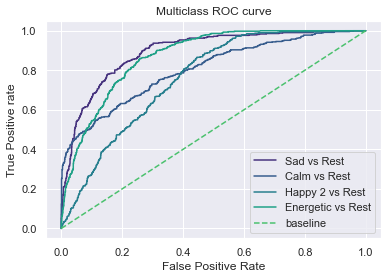

In [22]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_probs[:,i], pos_label=i)
    
# plotting  
sns.set_palette('viridis')
plt.plot(fpr[0], tpr[0], linestyle='-',label='Sad vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='-',label='Calm vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='-',label='Happy 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='-',label='Energetic vs Rest')

# add worst case scenario line
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC');  

#### **Model with Clusters**

In [23]:
# X audio features without clusters
X_cluster = df[['danceability', 
               'energy', 
               'loudness', 
               'speechiness', 
               'acousticness',
               'instrumentalness', 
               'liveness', 
               'valence', 
               'cluster']]

y = df['mood_map']

# set up train_test_split with stratification to include equal classes of each
X_train, X_test, y_train, y_test = train_test_split(X_cluster, y, 
                                                     test_size=0.3, 
                                                     stratify=y, 
                                                     random_state=42)

# standardize X data
x = MinMaxScaler()
X_train_x = x.fit_transform(X_train)
X_test_x = x.transform(X_test)

# LabelBinarizer for multiclass classification response variable
x = LabelBinarizer()
y_train_x = x.fit_transform(y_train)
y_test_x = x.transform(y_test)

In [24]:
def mood_model():
    
    n_input = X_train_x[0].shape

    model = Sequential()

    model.add(Dense(12, 
                    activation='relu', 
                    input_shape=(n_input)))
    
    model.add(Dense(8, 
                    activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(4, activation='softmax'))
    
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                               verbose=1, mode='auto')
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[['accuracy'],
                           [tf.keras.metrics.Precision()],
                           [tf.keras.metrics.Recall()]])

    return model

In [25]:
classifier_cl = KerasClassifier(build_fn=mood_model,
                             epochs=200,
                             verbose=0)

history_cl=classifier_cl.fit(X_train_x,
               y_train_x,
               validation_data=(X_test_x, y_test_x),
               epochs=200,
               verbose=0)
print(f'Train score: {classifier_cl.score(X_train_x, y_train_x)}')
print(f'Test score: {classifier_cl.score(X_test_x, y_test_x)}')

Train score: 0.5801172256469727
Test score: 0.5709401965141296


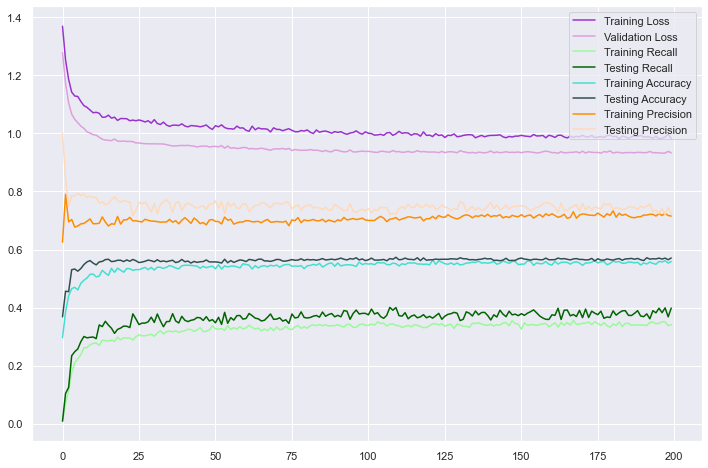

In [26]:
train_acc = history_cl.history['accuracy']
test_acc = history_cl.history['val_accuracy']
train_recall = history_cl.history['recall_1']
test_recall = history_cl.history['val_recall_1']
train_precision = history_cl.history['precision_1']
test_precision = history_cl.history['val_precision_1']
plt.figure(figsize=(12,8))
plt.plot(history_cl.history['loss'], label='Training Loss', color="darkorchid")
plt.plot(history_cl.history['val_loss'], label='Validation Loss', color='plum')
plt.plot(train_recall, label='Training Recall', color='palegreen')
plt.plot(test_recall, label='Testing Recall', color = 'darkgreen')
plt.plot(train_acc, label='Training Accuracy', color='turquoise')
plt.plot(test_acc, label='Testing Accuracy', color="darkslategray");
plt.plot(train_precision, label='Training Precision', color="darkorange")
plt.plot(test_precision, label='Testing Precision', color='peachpuff')
plt.legend();

In [27]:
y_preds=classifier_cl.predict(X_test_x)
y_pred_probs = classifier_cl.predict_proba(X_test_x)

C:\Users\Brianna\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


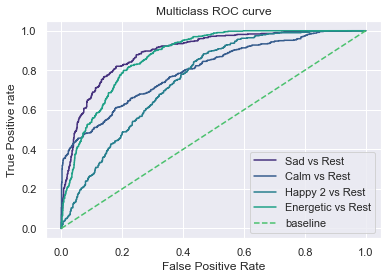

In [28]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_probs[:,i], pos_label=i)
    
# plotting  
sns.set_palette('viridis')
plt.plot(fpr[0], tpr[0], linestyle='-',label='Sad vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='-',label='Calm vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='-',label='Happy 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='-',label='Energetic vs Rest')

# add worst case scenario line
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC');  

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
x = mood['energy']
y = mood['danceability']
ax.scatter(x,y,c=mood['cluster'], s=40, cmap='viridis')
ax.legend(fontsize=12, title_fontsize=12)
ax.set_xlabel('Energy',fontsize=12)
ax.set_ylabel('Danceability',fontsize=12)
ax.set_zlabel('Loudness',fontsize=12)
ax.set_title("3D Scatter Plot of Songs Clusters");